In [1]:
import numpy as np
from analysis_pipeline import get_data
from analysis_pipeline import process_spikes as spk
from analysis_pipeline import make_plots

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'

# to save figure images, if desired
save_folder = 'G:/My Drive/Giocomo Lab/Presentations/Thesis/Figs/'

In [3]:
''' run analysis on 2-map sessions '''
mice = ['Pisa', 'Hanover', 'Calais', # cue poor
        'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich, NP9 = male
mouse_IDs = ['1c', '2a', '3a', '6a', '6b', '7a', '7b', '7c', '9a', ' 9b', '9c', '9d', '10a']
sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2'], # Hanover
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1'], # Seattle
            ['1005_2'],  # Portland
            ['1007_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
            ['1114_1', '1118_1'], # Vancouver
            ['1130_1', '1201_1', '1129_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 13
N sessions: 28


In [4]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [5]:
# load the data
N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        Y, B, A, cells = get_data.open_files(data_folder + 'gap_corrected/', m, s)
        d['Y'] = Y
        d['B'] = B
        d['A'] = A
        d['cells'] = cells

        # count the total number of cells
        N_cells += d['cells'].shape[0]

Calais_0713_2 corrected for mistargeting
Toronto_1112_1 corrected for mistargeting
Mumbai_1130_1 corrected for mistargeting


In [6]:
# fit lvl k-means to get neuron and trial factors
N = 2
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        d['kmeans'] = spk.fit_kmeans(Y, n_components=N, n_restarts=100)

In [21]:
# fit sklearn k-means to get neuron and trial factors
from sklearn.cluster import KMeans as sk_kmeans

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        # reshape Y into (n_trials, n_cells*n_pos_bins)
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))

        # fit model
        model_sk = sk_kmeans(n_clusters=N, n_init=100)
        model_sk.fit(Y_unwrapped)

        # store params
        d['sk_kmeans'] = {}
        W = model_sk.labels_
        H = model_sk.cluster_centers_
        d['sk_kmeans']['W'] = W
        d['sk_kmeans']['H'] = H

KeyboardInterrupt: 

In [7]:
# get map indices by observation and define map 0 as the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        d['idx'], d['map0_idx'] = spk.map_idx_by_obs(A, W)

In [8]:
dt = 0.02
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()
        B = d['B'].copy()
        map0_idx = d['idx']
        map1_idx = ~map0_idx
        
        # get tuning curves for each map
        FR_0, binned_pos = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=5, SEM=False)
        FR_1, binned_pos = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=5, SEM=False)
        d['FR'] = [FR_0, FR_1]

In [9]:
''' manifold alignment '''
from netrep.utils import rand_orth
from netrep.metrics import LinearMetric

In [16]:
def avg_shuffle_score(X, Y, n_shuff=10):
    shuffle_scores = np.zeros(n_shuff)
    for i in range(n_shuff):
        X_shuff = X @ rand_orth(X.shape[1])
        Y_shuff = Y @ rand_orth(Y.shape[1])
        shuffle_scores[i] = rmse(X_shuff, Y_shuff)
    return np.mean(shuffle_scores)

In [12]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y) ** 2))

In [13]:
def compute_misalignment(X, Y):
    # rotate the data to get the optimal alignment
    metric = LinearMetric(alpha=1.0)
    metric.fit(X, Y)
    X_aligned, Y_aligned = metric.transform(X, Y)
    
    # compute score
    obs_score = rmse(X, Y)
    best_score = rmse(X_aligned, Y_aligned)
    shuffle_score = avg_shuffle_score(X, Y)

    misalignment_score = (obs_score - best_score) / (shuffle_score - best_score)
    
    return misalignment_score, obs_score, best_score, shuffle_score

In [53]:
def format_data(H, n_cells, n_pos=80):
    V1 = H[0, :]
    V2 = H[1, :]

    # reshape to position bins x neurons
    V1 = V1.reshape((n_cells, n_pos))
    V1 = V1.T
    V2 = V2.reshape((n_cells, n_pos))
    V2 = V2.T
    
    # mean center
    V1 -= np.mean(V1, axis=0, keepdims=True)
    V2 -= np.mean(V2, axis=0, keepdims=True)

    # normalize
    V1 /= np.linalg.norm(V1)
    V2 /= np.linalg.norm(V2)
    
    return V1, V2

In [54]:
def format_data_FR(FR_0, FR_1):
    # reshape to position bins x neurons
    V1 = FR_0.copy()
    V2 = FR_1.copy()
    
    # mean center
    V1 -= np.mean(V1, axis=0, keepdims=True)
    V2 -= np.mean(V2, axis=0, keepdims=True)

    # normalize
    V1 /= np.linalg.norm(V1)
    V2 /= np.linalg.norm(V2)
    
    return V1, V2

In [55]:
# using the lvl k-means neuron factors
all_scores_lvl = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        H = d['kmeans']['H'].copy()
        n_cells = d['cells'].shape[0]
        V1, V2 = format_data(H, n_cells=n_cells)
        misalignment_score, obs_score, best_score, shuffle_score = compute_misalignment(V1, V2)
        
        d['misalignment_score_lvl'] = misalignment_score
        all_scores_lvl = np.append(all_scores_lvl, misalignment_score)

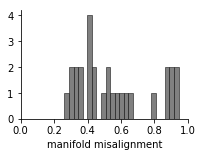

In [59]:
# plot misalignment scores across all sessions
f, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.hist(all_scores, edgecolor='k', facecolor='gray', lw=0.5, bins=25)
ax.set_xlim(0, 1)
ax.set_xlabel('manifold misalignment')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(save_folder + '/misalignment_scores_lvl.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# using the sklearn k-means neuron factors
all_scores_sk = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        H = d['sk_kmeans']['H'].copy()
        n_cells = d['cells'].shape[0]
        V1, V2 = format_data(H, n_cells=n_cells)
        misalignment_score, obs_score, best_score, shuffle_score = compute_misalignment(V1, V2)
        
        d['misalignment_score_sk'] = misalignment_score
        all_scores_sk = np.append(all_scores_sk, misalignment_score)

In [ ]:
# plot misalignment scores across all sessions
f, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.hist(all_scores_sk, edgecolor='k', facecolor='gray', lw=0.3, bins=8)
ax.set_xlim(0, 1)
ax.set_xlabel('manifold misalignment')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(save_folder + '/misalignment_scores_sk.png', dpi=400, bbox_inches='tight')
plt.show()

In [57]:
# using the true tuning curves
all_scores_tc = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        [FR_0, FR_1] = d['FR'].copy()
        V1, V2 = format_data_FR(FR_0, FR_1)
        misalignment_score, obs_score, best_score, shuffle_score = compute_misalignment(V1, V2)
        
        d['misalignment_score_tc'] = misalignment_score
        all_scores_tc = np.append(all_scores_tc, misalignment_score)

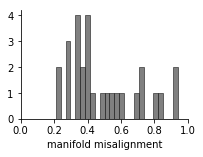

In [60]:
# plot misalignment scores across all sessions
f, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.hist(all_scores_tc, edgecolor='k', facecolor='gray', lw=0.5, bins=25)
ax.set_xlim(0, 1)
ax.set_xlabel('manifold misalignment')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(save_folder + '/misalignment_scores_tc.png', dpi=400, bbox_inches='tight')
plt.show()

In [30]:
''' calculate the manifold alignment for an example session '''
m = 'Pisa'
s = '0430_1'
d = data[m][s]
Y = d['Y'].copy()

# d['kmeans'] = spk.fit_kmeans(Y, n_components=N, n_restarts=100)
# d['similarity'] = spk.similarity(Y)

n_cells = d['cells'].shape[0]
n_pos = 80

In [31]:
# reshape the kmeans clusters into a position x neuron matrix of estimated tuning curves
H = d['kmeans']['H'].copy()
V1 = H[0, :]
V2 = H[1, :]

V1 = V1.reshape((n_cells, n_pos))
V1 = V1.T
V2 = V2.reshape((n_cells, n_pos))
V2 = V2.T

In [68]:
np.save(save_folderfolderfolder + 'X.npy', V1)
np.save(save_folder + 'Y.npy', V2)

In [32]:
''' sanity check - plot everything '''
''' get distance to k-means cluster on each trial 
see STAR Methods for more details
'''
A = d['A']
W = d['kmeans']['W']
sim = d['similarity']

# figure params
gs = gridspec.GridSpec(20, 1, hspace=1.5)
f = plt.figure(figsize=(2.3, 4))
c2 = 'k'

# plot distance to cluster
ax0 = plt.subplot(gs[11:15])
ax0.plot(W, lw=1.5, alpha=1)
ax0.set_xlim([0, W.shape[0]])
ax0.set_yticks([-1, 1])
ax0.set_ylabel('distance\nscore', fontsize=9, labelpad=1)
ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

# plot Euclidean similarity score
ax1 = plt.subplot(gs[:11])
im = ax1.imshow(sim, clim=[0.1, 0.7], aspect='auto', 
                cmap='Greys', interpolation='none')
ax1.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
ax1.set_ylabel('trial number', fontsize=9, labelpad=1)
ax1.set_title('network similarity', fontsize=10, pad=3)

# set axes
ax0.set_xticks([0, 200, 400])
ax1.set_yticks([0, 200, 400])
ax1.set_xticks([0, 200, 400])

plt.show()

KeyError: 'similarity'

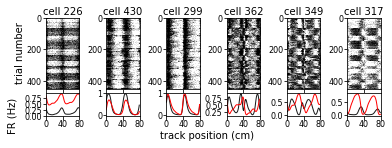

In [33]:
A = d['A']
B = d['B']  
cells = d['cells']
cell_IDs = [226, 430, 299, 362, 349, 317]

# figure params:
gs = gridspec.GridSpec(19, len(cell_IDs), hspace=1.5, wspace=0.8)
f = plt.figure(figsize=(6, 2.3)) 
PT_SIZE = 1
LW_MEAN = 1
LW_SEM = 0.3

for i, cell_ID in enumerate(cell_IDs):
    # draw raster plot
    ax0 = plt.subplot(gs[:11, i])
    sdx_0 = B[:, np.where(cells==cell_ID)[0][0]].astype(bool)
    ax0.scatter(A[:, 0][sdx_0], A[:, 2][sdx_0], color='k', lw=0, s=PT_SIZE, alpha=.1)
    ax0.set_xlim((0, 400))
    ylim_ax = [0, np.max(A[:, 2])]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_title('cell ' + str(cell_ID), fontsize=10, pad=3)

    # plot estimated tuning curves
    sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
    ax1 = plt.subplot(gs[11:15, i])
    ax1.plot(V1[:, sdx], 'k', lw=LW_MEAN, alpha=0.9)
    ax1.plot(V2[:, sdx], color='r', lw=LW_MEAN, alpha=1)

    if i == 0:
        ax0.set_ylabel('trial number', fontsize=10, labelpad=2)
        ax1.set_ylabel('FR (Hz)', fontsize=10, labelpad=7, horizontalalignment='right', y=0.8)
    if i == len(cell_IDs)//2:
        ax1.set_xlabel('track position (cm)', fontsize=10, labelpad=2, horizontalalignment='right', x=0.8)
    ax0.set_xticks(np.arange(0, 425, 200))
    ax0.tick_params(labelbottom=False, which='major', labelsize=8, pad=0.5)
    ax1.set_xlim([0, 80])
#     ax1.set_yticks([0, 20])
#     ax1.set_ylim([0, 27])
    ax1.set_xticks(np.arange(0, 100, 40))
    ax1.tick_params(which='major', labelsize=8, pad=0.5)
    
f.savefig(save_folder + m + '_' + s +'_H_example.png', dpi=400, bbox_inches='tight')
plt.show()

In [36]:
[FR_0, FR_1] = d['FR'].copy()
V1_fr, V2_fr = format_data_FR(FR_0, FR_1)

H = d['kmeans']['H']
n_cells = d['cells'].shape[0]
V1_lvl, V2_lvl = format_data(H, n_cells=n_cells)

In [41]:
V1_fr.shape

(227, 80)

IndexError: index 115 is out of bounds for axis 1 with size 80

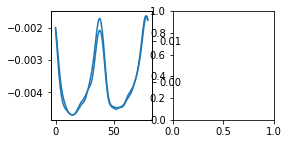

In [42]:
for cell_ID in cell_IDs:
    i = np.where(cells==cell_ID)[0][0]
    f, ax = plt.subplots(1, 2, figsize=(4, 2))
    ax[0].plot(V1_fr[i, :])
    ax0 = ax[0].twinx()
    ax0.plot(V1_lvl[:, i])
    
    ax[1].plot(V2_fr[:, i])
    ax1 = ax[1].twinx()
    ax1.plot(V2_lvl[:, i])
    
    plt.show()

In [34]:
# load data
A = d['A']
B = d['B']
dt = 0.02

# get map indices
W = d['kmeans']['W']
map0_idx = d['idx']
map1_idx = ~map0_idx

# get FR by position in each map for all cells   
FR, binned_pos, FR_sem = spk.tuning_curve(A[:, 0], B, dt, b=2, SEM=True)

In [57]:
# mean center
V1 -= np.mean(V1, axis=0, keepdims=True)
V2 -= np.mean(V2, axis=0, keepdims=True)

# normalize
V1 /= np.linalg.norm(V1)
V2 /= np.linalg.norm(V2)

In [58]:
# rotate the data to get the optimal alignment
metric = LinearMetric(alpha=1.0)
metric.fit(V1, V2)
V1_aligned, V2_aligned = metric.transform(V1, V2)

In [59]:
# shuffle by multiplying by a random KxK rotation matrix

shuff_1 = rand_orth(n_cells)
shuff_2 = rand_orth(n_cells)

# randomly rotate
shuff_V1 = V1 @ shuff_1
shuff_V2 = V2 @ shuff_2

In [60]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y) ** 2))

In [25]:
# compute the manifold misalignment score (RMSE relative to the optimal alignment and shuffle)
obs_score = rmse(V1, V2)
best_score = rmse(V1_aligned, V2_aligned)
shuffle_score = rmse(shuff_V1, shuff_V2)

misalignment_score = (obs_score - best_score) / (shuffle_score - best_score)
print(f'misalignment score = {misalignment_score:.4}')
print(f'observed score = {obs_score:.4}')
print(f'score after alignment = {best_score:.4}')
print(f'shuffle score = {shuffle_score:.4}')

NameError: name 'V1_aligned' is not defined

In [62]:
misalignment_score

0.651203900077848

In [63]:
shuffle_score

0.010526402028351749

In [64]:
best_score

0.0009780921359350094

In [65]:
obs_score

0.0071959887770286874